In [1]:
# =============================================================================
# Import Libraries and functions
# =============================================================================
from Data_preparation import data_processing_with_BH_scaled
import numpy as np
import torch
import gpytorch
import os
from gpytorch.mlls import ExactMarginalLogLikelihood 
import cloudpickle
from glob import glob
from scipy.special import eval_sh_legendre
from torch.optim import Adam
from gpytorch.kernels.keops import MaternKernel
from gpytorch.kernels import ScaleKernel, ProductKernel
from gpytorch.likelihoods.gaussian_likelihood import FixedNoiseGaussianLikelihood
from scipy.stats import entropy
import tqdm
import matplotlib.pyplot as plt
from gpytorch.means.mean import Mean
from torch import Tensor
from botorch.models.utils.inducing_point_allocators import (GreedyVarianceReduction, 
                                                            InducingPointAllocator)
%matplotlib inline

cwd = os.getcwd()
plots_folder = cwd
# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32  # possible numerical instabilities are solved by adding a jitter; reset to float64 for double precision (slower)

plots_folder = glob("..\\Plots\\")[0]
pickles_folder = glob("..\\Pickles\\")[0]


def Pickle_file(folder, filename, data):
    with open(folder + filename + '.pkl', mode='wb') as file:
        cloudpickle.dump(data, file)
        
def Unpickle_file(folder,filename):
    with open(folder+ filename + '.pkl', mode='rb') as file:
        data = cloudpickle.load(file)
    return data

# Load dataset - Data preparation
#### 1. Load data <small>(contains some hardcoding; CPT and BH data have been previously organized together in an incomplete (containing nans) dataset (this is not neccessary was done to be used to another project).</small>
#### 2. split train/test data
#### 3. Standardize CPT data (lognormal distribution assumption)
#### 4. Prepare borehole data - Dir. based transformation

In [2]:
# =============================================================================
# Load data
# =============================================================================
dis_depth = 185
num_vertical_des_points = 438 
num_cpts_w_bhs = 30
   
bh_ids = [0, 1, 12, 21, 27] 

num_bhs = 5

data, xt, yt, zt, grid, \
    z_mat, mapping, Dxy, Dz, depth_0 = data_processing_with_BH_scaled(
        num_cpts_w_bhs, num_bhs, 
        dis_depth, 
        num_vertical_des_points,
        cpt_par = "Ic")

ids = [i for i in range(data.shape[1])]
cpt_ids = [i for i in ids if i not in bh_ids]
# log-transform
data[:, [i for i in ids if i not in bh_ids]] = np.log(data[:, 
                                                           [i for i in ids if
                                                            i not in bh_ids]])   
excl_ids = [2, 13, 25, 26]

data  = data[:, [i for i in ids if i not in excl_ids]]
grid[1] = grid[1][[i for i in ids if i not in excl_ids]]
grid[2] = grid[2][[i for i in ids if i not in excl_ids]]

ids = [i for i in range(data.shape[1])]
bh_ids = [0, 1, 11, 19, 23]

cpt_ids = [i for i in ids if i not in bh_ids]


In [3]:
# create the train_x sets

data_cpts = data[:, cpt_ids]
y_nonnan_cpts = data_cpts.T.ravel()
y_nonnan_cpts = y_nonnan_cpts[~np.isnan(y_nonnan_cpts)]
len_nonnan_cpts = len(y_nonnan_cpts)
# create the train_x for cpts
depth_points = (grid[0] * (Dz - depth_0) + depth_0).numpy()

train_x_cpts = torch.zeros((len_nonnan_cpts, 3), dtype = torch.float64)
rowind = 0; 
for i, dat in enumerate(data_cpts.T):
    idni = len(dat[~np.isnan(dat)])

    train_x_cpts[rowind:rowind+idni, 0] = grid[0][:idni]
    train_x_cpts[rowind:rowind+idni, 1] = grid[1][cpt_ids[i]]
    train_x_cpts[rowind:rowind+idni, 2] = grid[2][cpt_ids[i]]
    rowind +=idni

In [4]:
# Same for boreholes

data_bhs = data[:, bh_ids]
y_nonnan_bhs = data_bhs.T.ravel()
y_nonnan_bhs = y_nonnan_bhs[~np.isnan(y_nonnan_bhs)]
len_nonnan_bhs = len(y_nonnan_bhs)
train_x_bhs = torch.zeros((len_nonnan_bhs, 3), dtype = torch.float64)
rowind = 0;
for i, dat in enumerate(data_bhs.T):
    idni = len(dat[~np.isnan(dat)])
    idni = len(dat[~np.isnan(dat)])
    train_x_bhs[rowind:rowind+idni, 0] = grid[0][:idni]
    train_x_bhs[rowind:rowind+idni, 1] = grid[1][bh_ids[i]]
    train_x_bhs[rowind:rowind+idni, 2] = grid[2][bh_ids[i]]
    rowind +=idni

In [5]:
# Standardize Ic data (lognormal dist)

mu_Ic = np.mean(np.exp(y_nonnan_cpts))
std_Ic = np.std(np.exp(y_nonnan_cpts))

def pars_log(mu_x,std_x):
    std_x_log = np.sqrt(np.log(std_x**2/mu_x**2 +1))
    mu_x_log = np.log(mu_x)-(std_x_log**2)/2    
    return mu_x_log,std_x_log

mu_Ic_log, std_Ic_log = pars_log(mu_Ic,std_Ic) 

In [6]:
# Prepare borehole data

y = data[:, bh_ids].copy().T.ravel()
y = y[~np.isnan(y)]
y_vec = y.astype(int)
y_discrete = torch.tensor(y_vec).long()
classes = np.unique(y_vec)
num_classes = len(classes)
Y = np.zeros((len(y_vec), len(classes)))
for i, e in enumerate(y_vec):
    Y[i, np.where(classes == e)[0]] = 1
    
# label transformation
a_eps = 0.002    

s2_tilde = np.log(1.0 / (Y + a_eps) + 1)
Y_tilde = np.log(Y + a_eps) - 0.5 * s2_tilde

In [7]:
# merge the data
train_y = torch.cat([torch.tensor(Y_tilde, dtype = dtype).mT.ravel(), 
                       (torch.tensor(y_nonnan_cpts, dtype = dtype) - mu_Ic_log) / std_Ic_log], -1)

data_cpts_stdzd = (y_nonnan_cpts - mu_Ic_log) / std_Ic_log

mean_ytilde = np.mean(Y_tilde)
std_Y_tilde = np.std(Y_tilde)

data_Ic = (y_nonnan_cpts.reshape(-1, 1) - mu_Ic_log) / std_Ic_log
train_Yvar_bhs = torch.tensor(s2_tilde, dtype = dtype).mT.ravel().unsqueeze(-1)
train_Yvar_cpts = torch.ones_like(torch.tensor(data_Ic, dtype = dtype)) * torch.tensor(1e-5) # 0.01 or setting, 0.0001

# create noise diagonal matrix
train_Yvar = torch.cat([train_Yvar_bhs, train_Yvar_cpts])

In [8]:
# create the train_x full with index 
num_tasks = num_classes+1
i_ind = torch.zeros(train_x_bhs.shape[0], num_tasks)
for i in range(num_tasks):
    i_ind[:, i] = torch.ones(train_x_bhs.shape[0]) * i
    
i_ind_cpts = torch.ones(train_x_cpts.shape[0])*int(num_classes)

# Needs to be modified according to the number of classes present in the training
# data

train_Xf = torch.cat([
     torch.cat([train_x_bhs, i_ind[:, 0].view(-1,1)], -1), 
     torch.cat([train_x_bhs, i_ind[:, 1].view(-1,1)], -1),
     torch.cat([train_x_bhs, i_ind[:, 2].view(-1,1)], -1),
     torch.cat([train_x_bhs, i_ind[:, 3].view(-1,1)], -1),
     torch.cat([train_x_bhs, i_ind[:, 4].view(-1,1)], -1),
     torch.cat([train_x_bhs, i_ind[:, 5].view(-1,1)], -1),
     torch.cat([train_x_bhs, i_ind[:, 6].view(-1,1)], -1),
     # torch.cat([train_x_bhs, i_ind[:, 7].view(-1,1)], -1),
     # torch.cat([train_x_bhs, i_ind[:, 8].view(-1,1)], -1),
     torch.cat([train_x_cpts, i_ind_cpts.view(-1,1)], -1),
 ], 0)

train_Xbhs = torch.cat([torch.cat([train_x_bhs, i_ind[:, i].view(-1,1)], -1) for i in range(num_classes)])
train_x_bhsn = train_Xbhs[:,:-1]

train_Xf = train_Xf.type(dtype=dtype)
train_i = train_Xf[:, -1].long()
train_X = train_Xf[:,:-1].type(dtype).detach()

train_Y = train_y.unsqueeze(-1)
train_yvar = train_Yvar

# Construct the model
### 1. Initialize inducing points from existing CPTs and BHs locations
### 2. define the LMC-based GP model

In [9]:
# initialize inducing points
num_ind = 1500

inducing_points1 = train_x_bhsn[torch.randperm(train_x_bhsn.size(0))[:num_ind]]
inducing_points2 = train_x_bhsn[torch.randperm(train_x_bhsn.size(0))[:num_ind]]
inducing_points3 = train_x_bhsn[torch.randperm(train_x_bhsn.size(0))[:num_ind]]
inducing_points4 = train_x_bhsn[torch.randperm(train_x_bhsn.size(0))[:num_ind]]
inducing_points5 = train_x_bhsn[torch.randperm(train_x_bhsn.size(0))[:num_ind]]
inducing_points6 = train_x_cpts[torch.randperm(train_x_cpts.size(0))[:num_ind]]

inducing_points = torch.cat([inducing_points1.unsqueeze(0), inducing_points2.unsqueeze(0), 
                             inducing_points3.unsqueeze(0), inducing_points4.unsqueeze(0), 
                             inducing_points5.unsqueeze(0),inducing_points6.unsqueeze(0)], dim = 0).to(dtype).to(device)


In [10]:
# We use the 1D SBL approach to determine the number and indices of BFs (legendre); for the algorithm (not provided here) see Ching 2017
drop_ids = [5,6,8,10,12,14,15,16,17,18,19]    # the selected BFs after running the 1D sbl algorithm

# -----------------------------------------------------------------------------------------------------------
# Legendre mean
def get_design_mat_1d(loc, deg):
    H = torch.tensor(np.array([eval_sh_legendre(n, loc) for n in range(deg)]).T, dtype = dtype)
    return H
   
class Legendre_poly(gpytorch.means.Mean):
    # currently works for constant trent in horizntal!!
    def __init__(self,  batch_shape = torch.Size(), mx = 1, my = 1, mz = 3):
        super().__init__()
        #self.register_parameter(name="weights", parameter=torch.nn.Parameter( 
        w =  torch.tensor([ 0.79351765,  0.01470026,  0.02857058,  
                          0.01003345, -0.11055545, -0.12710841,
                          0.12524614, -0.04141932,  0.02043685, 
                          -0.04141932,   0.02043685, -0.04141932,     
                          0.02043685, -0.04141932,  0.02043685, 
                          0.01470026,  0.02857058,  0.01003345, 
                          -0.11055545, -0.12710841, 0.12524614,
                          -0.04141932,  0.02043685, -0.04141932,  
                          0.02043685], dtype=dtype)[:mz].unsqueeze(0)


        self.mx = mx
        self.my = my
        self.mz = mz
        self.batch_shape = batch_shape

        self.register_parameter(name="weights", 
                                parameter=torch.nn.Parameter(
                                    torch.randn(*batch_shape,  1, self.mz,device=device,dtype=dtype)[..., :, :20- len(drop_ids)]))


    def Dmat( self, x):

        with torch.no_grad():

            if len(x.shape)<=2:
                Phi11 = get_design_mat_1d(x[:, 1].reshape(-1,1).detach().cpu().numpy(), self.mx ).squeeze(0)
                Phi22 = get_design_mat_1d(x[:, 2].reshape(-1,1).detach().cpu().numpy(), self.my ).squeeze(0)
     
                Phi_h = torch.einsum('...ik,...il->...ikl', Phi11, Phi22).squeeze(-1).to(device)
            
                Phi_v = get_design_mat_1d(x[:, 0].reshape(-1,1).detach().cpu().numpy(), self.mz).squeeze(0).to(device)


                #=====================================================================
                Phi_v = Phi_v[..., :, [j for j in torch.arange(self.mz) if j not in drop_ids]]
                #=====================================================================
                res = torch.einsum( '...i,...jk,...ji ->  ...j', self.weights, Phi_h, Phi_v ).squeeze(-2)

                
                return res
    
            else:
                res2 =0
                for i in range(num_latents):
                    Phi11 = get_design_mat_1d(x[i, :, 1].reshape(-1,1).detach().cpu().numpy(), 1 ).squeeze(0)
                    Phi22 = get_design_mat_1d(x[i, :, 2].reshape(-1,1).detach().cpu().numpy(), 1 ).squeeze(0)
     
                    Phi_h = torch.einsum('...ik,...il->...ikl', Phi11, Phi22).squeeze(-1).to(device)
                    Phi_v = get_design_mat_1d(x[i, :, 0].reshape(-1,1).detach().cpu().numpy(), self.mz).squeeze(0).to(device)

                    #=====================================================================
                    Phi_v = Phi_v[..., :, [j for j in torch.arange(self.mz) if j not in drop_ids]]
                    #=====================================================================

                    res2=torch.einsum( '...i,...jk,...ji ->  ...j', self.weights, Phi_h, Phi_v ).squeeze(-2)

                    return res2
    
    def forward( self, x):
        res = self.Dmat(x)

        return res

In [18]:
# Build the model
num_latents = 6

class MultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, likelihood):

        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
        )

        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        ),
            num_tasks=num_tasks,
            num_latents=num_latents,
            latent_dim=-1
        )
        
        super(MultitaskGPModel, self).__init__(variational_strategy)
        self.likelihood = likelihood
        
        # mean (legendre or constant)
        #self.mean_module = Legendre_poly(batch_shape=torch.Size([num_latents]), mx=1, my=1, mz=20)  
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        
        self.covar_module = ScaleKernel(ProductKernel(MaternKernel(nu=0.5,active_dims=torch.tensor([0]),
                                                                    batch_shape=torch.Size([num_latents])),               
                                    MaternKernel(nu=0.5, active_dims=torch.tensor([1, 2]),
                                                  batch_shape=torch.Size([num_latents]))),
                                        batch_shape=torch.Size([num_latents]))

    def forward(self, x):
        mean_x = self.mean_module(x) 
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [19]:
# To load a trained model


# state_dict = torch.load('VLMC_strat_Ic-uscs_1500ind_constant.pth')

# likelihood  = FixedNoiseGaussianLikelihood(noise=train_Yvar.squeeze(-1))
# model = MultitaskGPModel(inducing_points = inducing_points, likelihood = likelihood)
# model.load_state_dict(state_dict)
# train_X, train_y, train_i = train_X.to(device).contiguous(), train_y.to(device).contiguous(), train_i.to(device).contiguous()
# train_yvar = train_yvar.to(device).contiguous()
# model = model.to(device)
# likelihood = likelihood.to(device)


In [20]:
# Helper function for inititalizing the inducing points (alternatively we keep the randomly selected from CPTs and BHs locations)
inducing_point_allocator = GreedyVarianceReduction()
def init_inducing_points(
        inputs: Tensor,
    ) -> Tensor:
        r"""
        Reinitialize the inducing point locations in-place with the current kernel
        applied to `inputs` through the model's inducing point allocation strategy.
        The variational distribution and variational strategy caches are reset.

        Args:
            inputs: (\*batch_shape, n, d)-dim input data tensor.

        Returns:
            (\*batch_shape, m, d)-dim tensor of selected inducing point locations.
        """
        var_strat = model.variational_strategy
        var_strat = var_strat.base_variational_strategy
        with torch.no_grad():
            num_inducing = var_strat.inducing_points.size(-2)
            inducing_points = inducing_point_allocator.allocate_inducing_points(
                inputs=inputs,
                covar_module=model.covar_module,
                num_inducing=num_inducing,
                input_batch_shape=torch.Size([num_latents]),
            )
            var_strat.inducing_points.copy_(inducing_points)
            var_strat.variational_params_initialized.fill_(0)

        return inducing_points


In [21]:
# call the model and initialize hyperparameters

likelihood  = FixedNoiseGaussianLikelihood(noise=train_Yvar.squeeze(-1))
model = MultitaskGPModel(inducing_points = inducing_points, likelihood = likelihood)
# ini_inducing_points = init_inducing_points(train_X)
# model = MultitaskGPModel(inducing_points = ini_inducing_points, likelihood = likelihood)

model.covar_module.base_kernel.kernels[0].lengthscale = torch.tensor([0.0271], dtype = dtype, device = device)  #ini
model.covar_module.base_kernel.kernels[1].lengthscale = torch.tensor([0.15], dtype = dtype, device = device)

train_X, train_y, train_i = train_X.to(device).contiguous(), train_y.to(device).contiguous(), train_i.to(device).contiguous()
train_yvar = train_yvar.to(device).contiguous()
model = model.to(device)
likelihood = likelihood.to(device)

# Train model
### 1. minibatch training (4 batches of approx n=5000)
### 2. Adam optimizer: (lr is adjusted approx. (lr=0.01 for 100 ep., lr=0.005 for 50 ep., lr=0.001 for >100ep.)) or use a scheduler
##### Note: levels of accuracy and precision strongly depend on the optimization (lr, parameters and initialization); experimenting with learning rate, number of inducing points, initialization of inducing points and number of latent functions can enhance performance.

In [22]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_X, train_i, train_y, train_yvar)
train_loader = DataLoader(train_dataset, batch_size=5000, shuffle=True)

In [25]:
# Train the model

hyperparameter_optimizer  = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.001)

model.train()
model.likelihood.train()
likelihood.train()

#instead of manually adjusting lr, a scheduler can be used e.g., 
#scheduler = torch.optim.lr_scheduler.MultiStepLR(hyperparameter_optimizer, milestones=[100, 150, 225, 300, 400], gamma=0.5)

#-------------------------------------------------------------------------------------------------------------------
mll = lambda noise: gpytorch.mlls.PredictiveLogLikelihood(FixedNoiseGaussianLikelihood(noise=noise.squeeze(-1)),
                                                             model, num_data=train_y.numel())
#-------------------------------------------------------------------------------------------------------------------
num_epochs = 200 

epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
loss_curve = []
for i in epochs_iter:
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    loss_sum = 0
    for x_batch, i_batch, y_batch, y_var_batch in minibatch_iter:

        hyperparameter_optimizer.zero_grad()
        output = model(x_batch, task_indices = i_batch)

        loss = -mll(y_var_batch)(output, y_batch)
        loss_sum += loss
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        hyperparameter_optimizer.step()
    #scheduler.step()   #if a scheduler is used
    loss_mean = loss_sum / 4 
    loss_curve.append(loss_mean.cpu().detach().numpy())
    #epochs_iter.set_postfix(loss_mean=loss_mean.item(), lr = scheduler.get_last_lr())
    epochs_iter.set_postfix(loss_mean=loss_mean.item())

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\ozinas\.conda\envs\spyder-cuda\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(


Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\ozinas\.conda\envs\spyder-cuda\Lib\site-packages\linear_operator\operators\_linear_operator.py:2155: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.. Using symeig method.
  warnings.warn(


Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

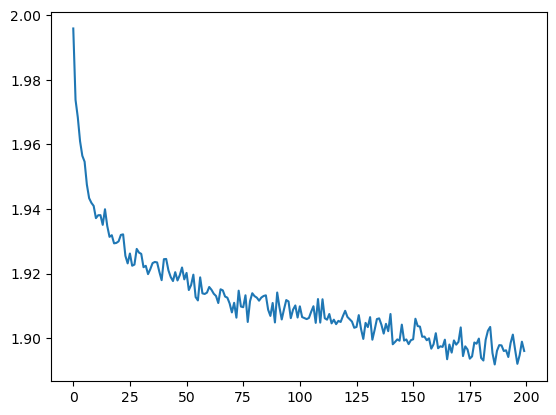

In [26]:
plt.figure()
plt.plot(np.arange(len(loss_curve)),loss_curve)

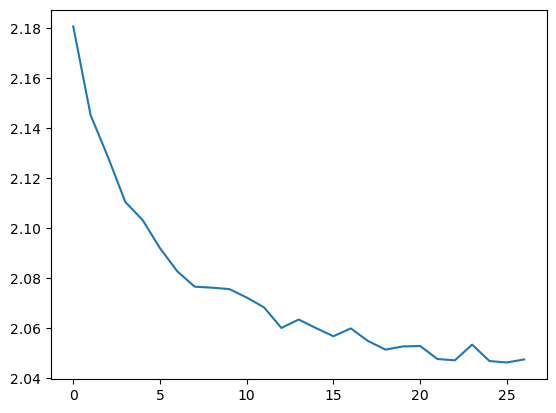

In [45]:
plt.figure()
plt.plot(np.arange(len(loss_curve2)),loss_curve2)

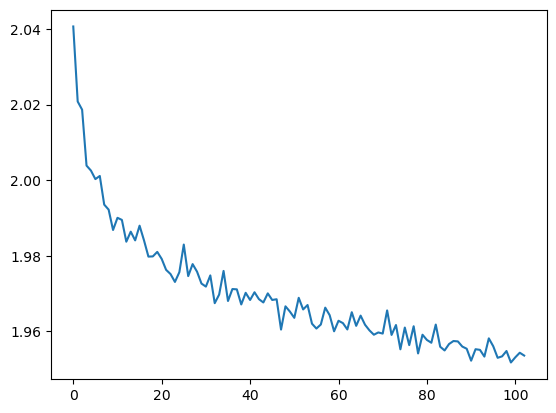

In [47]:
plt.figure()
plt.plot(np.arange(len(loss_curve3)),loss_curve3)

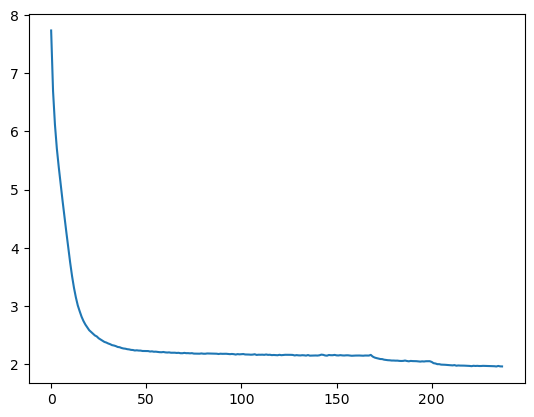

In [27]:
plt.figure()
plt.plot(np.arange(len(loss_curve123)),loss_curve123)

In [39]:
# save the trained model

#torch.save(model.state_dict(), 'VLMC_strat_Ic-uscs_1500ind_constant.pth')

In [27]:
arr = model.variational_strategy.lmc_coefficients.cpu().detach().numpy()
np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})
print(arr)

[[-2.7817 2.1914 -0.1622 -0.5616 0.6793 1.4158 1.4473 0.0005]
 [1.7729 -1.0512 -0.0988 -0.1636 2.8510 0.9727 0.1543 -0.6975]
 [0.9365 3.2262 0.1011 -0.4239 0.3689 -2.0653 1.9648 -0.0020]
 [-1.3416 -1.1709 -0.0323 -0.0180 1.8645 -2.3863 0.5033 -0.0006]
 [0.4996 -0.7733 2.5024 2.4620 -0.2021 0.5445 4.2654 0.0169]
 [0.8774 0.9131 1.4128 1.7334 2.4717 0.5608 -1.1336 0.5780]]


In [28]:
#model.state_dict()

# Predict
### 1. 1D (2745 pred points per borehole)
### 2. 2D (300 x 500) (Z x X)
### 3. 3D (300 x 202 x 100 ) (Z x X x Y)

from IPython.display import Image
![title](site_plan.png)

In [29]:
# Predictions (at verification boreholes)
Dz = np.max(z_mat) 

# xcoords (BH_9,BH_1,H_5,BH_3) = [55.7300 104.2000 149.7200 192.4700] m
# ycoords (BH_9,BH_1,H_5,BH_3) = [16.1100 71.5800 21.6400 70.8200] m

x_p_m = np.array([0.27609611, 0.51622492, 0.74173892, 0.95352985])       # the scaled (divided by Dx) locations of the verification boreholes 
y_p_m = np.array([0.07981174, 0.35461977, 0.10720832, 0.35085459])       # the scaled (divided by Dx) locations of the verification boreholes 


nv_test = 2745 - int(1.86/0.01) + 1
nh_test = (x_p_m).shape[0]
n_uscs_samples = 400

z_t = np.linspace(0.00, np.max(grid[0].numpy()), nv_test)
z_t = np.linspace(0.00, 1, nv_test)

x_t = x_p_m
y_t = y_p_m

n_v = (z_t).shape[0]
n_h = (x_t).shape[0]

N = n_v * n_h

grid_test = [torch.from_numpy(z_t), 
             torch.from_numpy(x_t), 
             torch.from_numpy(y_t)]

test_zx = gpytorch.utils.grid.create_data_from_grid([grid_test[0], grid_test[1]])
test_zy = gpytorch.utils.grid.create_data_from_grid([grid_test[0], grid_test[2]])
test_x = torch.stack([test_zx[:,0].view(-1,1), 
                       test_zx[:,1].view(-1,1), 
                       test_zy[:,1].view(-1,1)]).squeeze().t().to(train_X)

In [30]:
test_dataset = TensorDataset(test_x, test_x)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle=False)



model.eval()
likelihood.eval()

means = []; lower = []; upper = []
probs_batched = []
#pred_samples_batched = []
with torch.no_grad(), gpytorch.settings.fast_pred_var(True), gpytorch.settings.fast_computations(
        covar_root_decomposition=False,  solves=False),\
    gpytorch.settings.use_toeplitz(False):
        for x_batch_t,_ in test_loader:
            num = len(torch.unique(x_batch_t[:,0]))
            predictions = likelihood(model(x_batch_t))
            means.append(predictions.mean.cpu())
            l, u = predictions.confidence_region()
            lower.append(l)
            upper.append(u)

            samples_uscs = predictions.sample(torch.Size((400,)))
            pred_samples_uscs = samples_uscs.exp()[:,..., :len(classes)]    
            probs_batched.append((pred_samples_uscs / pred_samples_uscs.sum(-1, keepdim=True)).mean(0))


C:\Users\ozinas\.conda\envs\spyder-cuda\Lib\site-packages\gpytorch\likelihoods\gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


In [31]:
mean = torch.concat([means[i] for i in range(len(means))], dim=0)
lower = torch.concat([lower[i] for i in range(len(lower))], dim=0)
upper = torch.concat([upper[i] for i in range(len(upper))], dim=0)
probabilities = torch.cat([probs_batched[i] for i in range(len(probs_batched))], dim=0)[:,:len(classes)].reshape(nh_test,nv_test,num_classes).cpu()


In [32]:
post_mean_ic = mean[..., -1].cpu()  * std_Ic_log + mu_Ic_log         
lower_Ic = lower[..., -1].cpu() * std_Ic_log + mu_Ic_log        
upper_Ic = upper[..., -1].cpu() * std_Ic_log + mu_Ic_log     

In [33]:
# entropy, classification metrics
bhs = ["bh9", "bh1", "bh5", "bh3"]
depth = z_t * (Dz-depth_0) + depth_0      

inv_map = {v: k for k, v in mapping.items()}
bounds = [1.31, 2.05, 2.6, 2.95, 3.6]
depth_max = np.max(depth_points) 

N = np.array([i for i in range(num_classes)])
R = [inv_map[classes[i]] for i in N] 

def most_probable_uscs(prob, mapping, inv_map):
    num_classes = prob.shape[-1]
    max_probs = np.zeros(prob.shape[0])
    probs_np = prob.cpu().detach()
    most_prob_profile = np.zeros(prob.shape[0])
    H = np.zeros(prob.shape[0])
    for i in range(len(prob)):
        max_prob_id = np.argmax(probs_np[i].numpy())
        most_prob_profile[i] = (max_prob_id + mapping[R[0]])
        max_probs[i] = probs_np[i][max_prob_id]
        H[i] = entropy(probs_np[i].numpy(), base = 2) / entropy(np.ones(num_classes) / num_classes , base = 2)
    return most_prob_profile, max_probs, H


most_prob_profile = np.empty((nh_test, nv_test))
max_probs = np.empty((nh_test, nv_test))
H = np.empty((nh_test, nv_test))

for i, probs in enumerate(probabilities):
    most_prob_profile[i], max_probs[i], H[i] = most_probable_uscs(probs, mapping, inv_map)


In [34]:
from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import accuracy_score
import pandas as pd

# classifier
def load_data_classes(file):
    return np.array(pd.read_excel(glob("..\\Input\\"+file)[0]),dtype=str)

classes_bh_all = load_data_classes("bhs_all.xlsx")
# classes_bh_all = load_data_classes("bhs_all.xlsx")

label_encoder = LabelEncoder()
# Fit the LabelEncoder to the USCS class labels and transform them into categorical variables
encoded_classes = label_encoder.fit_transform(classes_bh_all.ravel(order="f")).reshape(classes_bh_all.shape, order = "f")
or_classes = classes_bh_all[:, [0, 2, 4, 8]]
or_classes = classes_bh_all[:, [8, 0, 4, 2]]


train_classes_bh = encoded_classes[:, [1, 3, 5, 6, 7]]
test_classes_bh = or_classes

df_test = pd.DataFrame(test_classes_bh,
                       columns = ["BH_9", "BH_1", "BH_5", "BH_3"])
z_test = z_mat[:,0]
df_test["z"] = z_test

C:\Users\ozinas\AppData\Local\Temp\ipykernel_6652\3494112362.py:133: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\ozinas\AppData\Local\Temp\ipykernel_6652\3494112362.py:133: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\ozinas\AppData\Local\Temp\ipykernel_6652\3494112362.py:133: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\ozinas\AppData\Local\Temp\ipykernel_6652\3494112362.py:133: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


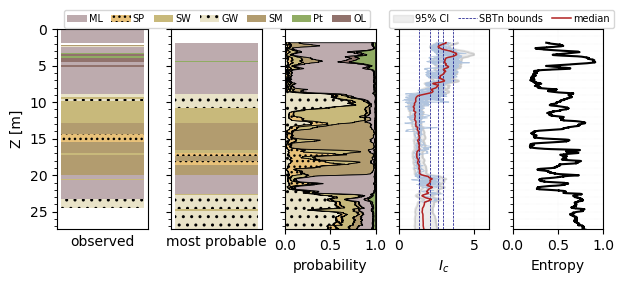

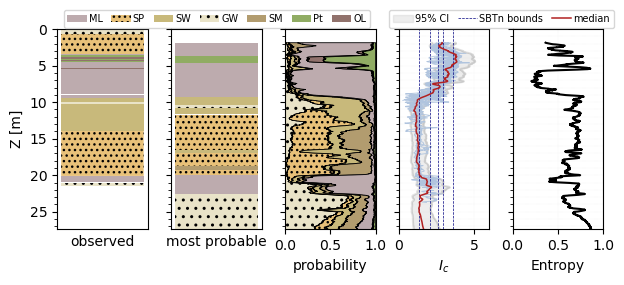

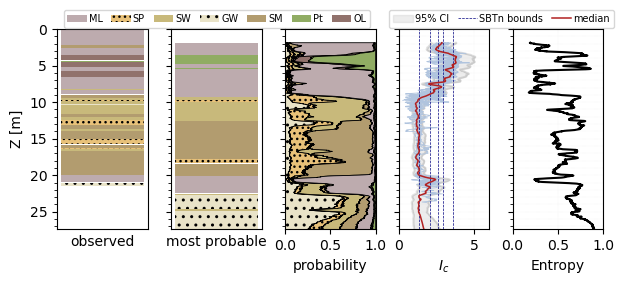

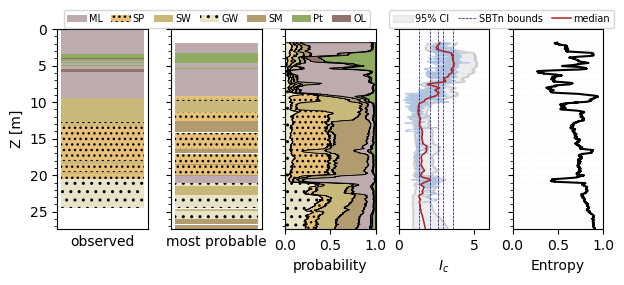

In [35]:
# =============================================================================
# Plots (1D)
# =============================================================================
from matplotlib.ticker import AutoMinorLocator

hatches=['..','...','','','','','']
Rn = ['GW', 'SP', 'SW', 'SM', 'ML', 'OL', 'Pt']  # manual ordering accordieng to soil!
indx = []
for i,c in enumerate(Rn):
    indx.append(R.index(c))
    

# lithological plots
# SEE: https://towardsdatascience.com/displaying-lithology-data-using-python-and-matplotlib-58b4d251ee7a

lithology_colors = [(0.9137254901960784, 0.8895686274509804, 0.7843921568627451),      
                    (0.9090, 0.75640, 0.4750),              
                    (0.7843137254901961, 0.7239215686274509, 0.4835294117647059),
                    (0.6980392156862745, 0.6134901960784314, 0.4369411764705882),
                    (0.7411764705882353, 0.6687058823529413, 0.6831764705882354),
                    (0.5686274509803921, 0.4478431372549019, 0.4219607843137255), 
                    (0.5660, 0.6740, 0.3880)]


lithology_numbers = {'ML': {'name':'ML', 'lith_num':1, 'hatch': hatches[Rn.index("ML")], 'color':lithology_colors[Rn.index("ML")]},
                 'SP': {'name':'SP', 'lith_num':2, 'hatch': hatches[Rn.index("SP")], 'color':lithology_colors[Rn.index("SP")]},
                 'SW': {'name':'SW', 'lith_num':3, 'hatch': hatches[Rn.index("SW")], 'color':lithology_colors[Rn.index("SW")]},
                 'GW': {'name':'GW', 'lith_num':4, 'hatch':hatches[Rn.index("GW")], 'color':lithology_colors[Rn.index("GW")]},
                 'SM': {'name':'SM', 'lith_num':5, 'hatch':hatches[Rn.index("SM")], 'color':lithology_colors[Rn.index("SM")]},             
                 'Pt': {'name':'Pt', 'lith_num':11, 'hatch':hatches[Rn.index("Pt")], 'color':lithology_colors[Rn.index("Pt")]},
                 'OL': {'name':'OL', 'lith_num':12, 'hatch':hatches[Rn.index("OL")], 'color':lithology_colors[Rn.index("OL")]}}

# ==============================================================================
# Grid plot with most relevant profiles
# =============================================================================

                            
for loc in range(len(bhs)):      
    Pr_uscs = probabilities[loc].detach().T[indx]

    df = pd.DataFrame(data=max_probs[loc], columns = ["prob"])
    df["class"] =  most_prob_profile[loc]
    df["z"] = np.round(depth, 2)
    df["x"] = 2
    df["H_uscs"] = H[loc]
    df['class'] = df['class'].map(inv_map)                                      
                                          
    fig = plt.figure(figsize = (7.05, 2.6))

    gs = fig.add_gridspec(1, 5, hspace=0, wspace=0.255)
    (ax1, ax2, ax3, ax4, ax5) = gs.subplots(sharex='col', sharey='row')
    for key in lithology_numbers.keys():
        color = lithology_numbers[key]['color']
        hatch = lithology_numbers[key]['hatch']
        ax2.fill_betweenx(df['z'], 0, 1, where=(df['class']==key),
                              facecolor=color, hatch=hatch, label=key)
    
    for key in lithology_numbers.keys():
        color = lithology_numbers[key]['color']
        hatch = lithology_numbers[key]['hatch']
        ax1.fill_betweenx(df_test["z"], 0, 1, where=(df_test.iloc[:,loc]==key),
                             facecolor=color, hatch=hatch, label=key)
        
    polys = ax3.stackplot(df['z'], Pr_uscs,
                 labels=Rn,edgecolors="black", colors = lithology_colors, linewidth=0.6)
    xlims = ax3.get_xlim()
    xlims = (0, depth_max)
    ylims = ax3.get_ylim()
    for poly in polys:
        for path in poly.get_paths():
            path.vertices = path.vertices[:, ::-1]
            
    for stack, hatch in zip(polys, hatches):
        stack.set_hatch(hatch)

    ax3.set_xlim(ylims)  # use old y limits
    ax3.set_ylim(xlims[::-1])  # use old x limits, reversed

    ax4.plot(lower_Ic.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
            df['z'],
                      color = "black", alpha = 0.1)
    ax4.plot(upper_Ic.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
            df['z'],
                      color = "black", alpha = 0.1)
    ax4.fill_betweenx(df['z'], 
                      lower_Ic.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
                      upper_Ic.exp().squeeze()[loc*nv_test:nv_test*(loc+1)], 
                      color = "darkgrey", alpha = 0.2, label='95% CI')# ax.set_xlim(0,5)
    for i, dat in enumerate(data_cpts.T):
        if i==0:  
            ax4.plot(np.exp(dat), zt*(Dz-1.86)+1.86, '-', 
                    color = "lightsteelblue", linewidth = 0.6) #, label='training data'
        else:
            ax4.plot(np.exp(dat), zt*(Dz-1.86)+1.86, '-', 
                    color = "lightsteelblue", linewidth = 0.6)       # To plot the traiining data
    for xc in bounds:
        if xc == bounds[0]:
            ax4.axvline(x=xc, linestyle = "dashed", color='navy', 
                    linewidth = 0.5, label = "SBTn bounds")
        else:
            ax4.axvline(x=xc, linestyle = "dashed", color='navy', 
                    linewidth = 0.5)
            
    ax4.plot(post_mean_ic.exp()[loc*nv_test:nv_test*(loc+1)], 
            df['z'], 
            '-', color='firebrick', linewidth = 1.1, label='median')        
    ax5.plot(H[loc], df['z'], color = "black")
    ax5.set_xlim(0,1)
    ax3.set_xlim(0,1)
    ax4.set_xlim(0,6.0)

    ax4.set_xlabel(r'$I_c$')
    ax4.legend(bbox_to_anchor=(2.42, 1.12), ncol=3, fontsize = 7, handletextpad=0.2, columnspacing=0.9)

    ax1.set_xlabel("observed")
    ax1.set_ylabel("Z [m]")
    ax2.set_xlabel("most probable")
    ax3.set_xlabel("probability")
    ax5.set_xlabel("Entropy")
    ax5.grid(which="both", color="darkgrey", alpha=.3, linewidth=0.25,linestyle=":")
    ax5.grid(which="both", color="darkgrey", alpha=.3, linewidth=0.25,linestyle=":")
    ax4.grid(which="both", color="darkgrey", alpha=.3, linewidth=0.25,linestyle=":")
    ax4.grid(which="both", color="darkgrey", alpha=.3, linewidth=0.25,linestyle=":")
    ax5.invert_yaxis() 
    ax4.invert_yaxis() 
    ax3.invert_yaxis() 
    ax2.invert_yaxis() 
    ax2.set_xticks([])  
    ax1.set_xticks([])  
    ax1.yaxis.set_minor_locator(AutoMinorLocator())
    ax1.legend(bbox_to_anchor=(3.5, 1.12), ncol = num_classes, fontsize = 7,handletextpad=0.2, columnspacing=0.9)

    fig.show()   

In [36]:
encoded_classes = np.array(encoded_classes, dtype = float)
encoded_classes[encoded_classes == np.max(encoded_classes)] = np.nan


test_classes_bh_num = encoded_classes[:, [8, 0, 4, 2]]
y_test = test_classes_bh_num.T.ravel()
y_test = y_test[~np.isnan(y_test)]
y_vec_test = y_test.astype(int)
y_discrete_test = torch.tensor(y_vec_test).long()
classes_test = np.unique(y_vec_test)
num_classes = len(classes)
Y_test = np.zeros((len(y_vec_test), len(classes_test)))
#Y_pred = np.zeros((len(y_vec_test), len(classes_test)))

for i, e in enumerate(y_vec_test):
    # print(i, e)
    Y_test[i, np.where(classes_test == e)[0]] = 1
    #Y_pred[i, np.where(classes_test == e)[0]] = 1

In [37]:
def cross_entropy(targets, predictions,  epsilon=1e-12):
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

test_loc 0
cross entropy skl 1.005911990978063
cross entropy manual 1.0482303394501902

accuracy score:  0.7096060203629925

precision score:  0.6971884693542316
------------------------------------
test_loc 1
cross entropy skl 1.2391276240444644
cross entropy manual 1.2879266079216662

accuracy score:  0.6564573762123532

precision score:  0.6660225343437464
------------------------------------
test_loc 2
cross entropy skl 1.0489829668008706
cross entropy manual 1.0977819494488532

accuracy score:  0.6697294538029607

precision score:  0.6385391670312088
------------------------------------
test_loc 3
cross entropy skl 1.222031934714488
cross entropy manual 1.2643502837342993

accuracy score:  0.6458610004426738

precision score:  0.7288233017337927
------------------------------------

accuracy score total:  0.6709340919867236

precision score total:  0.6719979698871377
cross entropy skl total 1.12794380934157


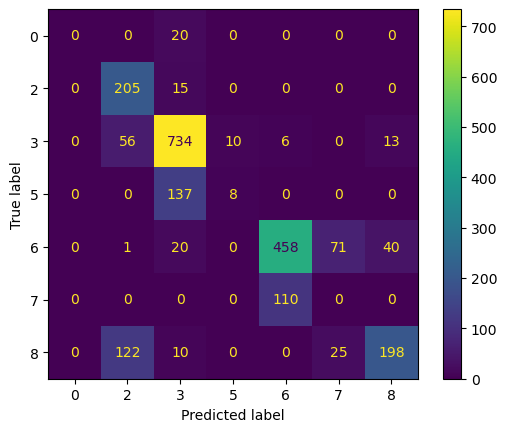

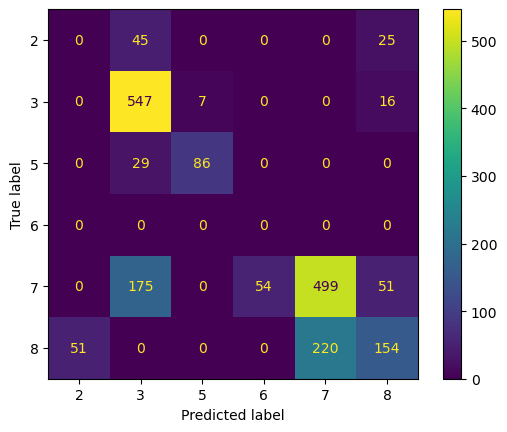

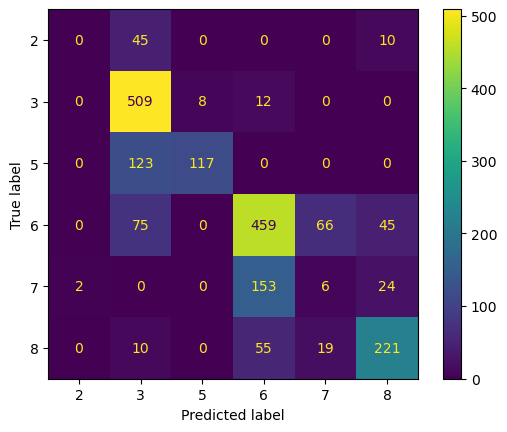

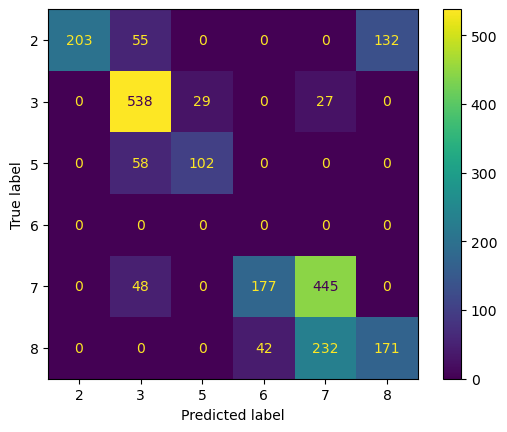

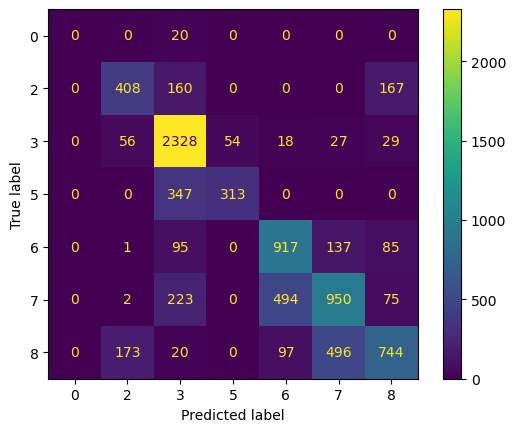

In [38]:
# The number of nonnan elements in each testing borehole
bhi_test_num_el = (np.ones(4)*len(encoded_classes) - np.isnan(encoded_classes[:, [8, 0, 4, 2]]).sum(axis=0)).astype(int)

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score, roc_auc_score, log_loss
#from gpytorch.metrics import mean_standardized_log_loss



from collections import defaultdict
dict_metrics_bh = {i: defaultdict(list) for i in range(len(bhs))}

y_true=[]; y_pred=[]; targets = []; inputs = []#to test entire set of bhs
for loc in range(len(bhs)):   

    # dict_metrics_bh["z_bh"].append(df_test["z"][:bhi_test_num_el[loc]])
    # dict_metrics_bh["y_test_bh"].append( torch.tensor(Y_test[:bhi_test_num_el[bh_loc], :][np.where(z_bh9>=1.86)] ))
    z_bh = df_test["z"][:bhi_test_num_el[loc]]
    dict_metrics_bh[loc]["z_bh"]=(df_test["z"][:bhi_test_num_el[loc]])
    dict_metrics_bh[loc]["y_test_bh"]=( torch.tensor(Y_test[:bhi_test_num_el[loc], :][np.where(z_bh>=1.86)] ))

   # y_test_cat_bh[y_test_cat_bh==5] = 4
    dict_metrics_bh[loc]["y_test_bh_cat"]=np.array(encoded_classes[:, [8, 0, 4, 2]][np.where(z_bh>=1.86)] [:, loc], dtype=int)
   
#     #===========================================
#     #merge OL and Pt (only for predictions)
    dict_metrics_bh[loc]["y_test_bh_cat"][dict_metrics_bh[loc]["y_test_bh_cat"]==4] = 5
#     #===========================================
    pred_probs_bh =  probabilities[loc][np.where(depth<=max(z_bh))]
    z_bh = z_bh[z_bh>=1.86]

    #dict_metrics_bh[loc]["pred_probs_bh"] = probabilities[loc][np.where(depth<=max(z_bh))]
    pred_probs_bh = torch.cat([torch.zeros(len(pred_probs_bh), 2), pred_probs_bh], -1).clone().detach().requires_grad_(True)
    pred_class = np.array(most_prob_profile[loc][np.where(depth<=max(z_bh))],dtype=int)
    dict_metrics_bh[loc]["pred_probs_bh"] = pred_probs_bh
    dict_metrics_bh[loc]["pred_class_bh"] = pred_class

    input = dict_metrics_bh[loc]["pred_probs_bh"]
    target = dict_metrics_bh[loc]["y_test_bh"]
    
    print("test_loc", loc)

    targets.append(target.numpy()); inputs.append(input.detach())
    print("cross entropy skl", log_loss( target.numpy(), input.detach().numpy()))
    print("cross entropy manual", cross_entropy( target.numpy(), input.detach().numpy()))
    
    print("\naccuracy score: ",  accuracy_score(dict_metrics_bh[loc]["y_test_bh_cat"], 
                                                     dict_metrics_bh[loc]["pred_class_bh"]))
    
    print("\nprecision score: ",  precision_score(dict_metrics_bh[loc]["y_test_bh_cat"], 
                                                     dict_metrics_bh[loc]["pred_class_bh"], average = "weighted", zero_division = 0.0 ))
    
    ConfusionMatrixDisplay.from_predictions(dict_metrics_bh[loc]["y_test_bh_cat"],
                                            dict_metrics_bh[loc]["pred_class_bh"],
                                           #display_labels=np.sort(pd.Series(dict_metrics_bh[loc]["y_test_bh_cat"]).map(inv_map).unique().tolist())     
                                           )
    
    print("------------------------------------")
    y_true.append(dict_metrics_bh[loc]["y_test_bh_cat"])
    y_pred.append(dict_metrics_bh[loc]["pred_class_bh"])


    
print("\naccuracy score total: ",  accuracy_score(np.concatenate(y_true), 
                                                    np.concatenate(y_pred)
                                                  ))
print("\nprecision score total: ",  precision_score(np.concatenate(y_true), 
                                                    np.concatenate(y_pred), 
                                                  average = "weighted", zero_division = 0.0 ))
print("cross entropy skl total", log_loss( np.concatenate(targets), np.concatenate(inputs)))

ConfusionMatrixDisplay.from_predictions(np.concatenate(y_true),
                                        np.concatenate(y_pred),
                                        #display_labels=np.sort(pd.Series(dict_metrics_bh[loc]["y_test_bh_cat"]).map(inv_map).unique().tolist())     
                                        )



### 2D cross cuts A-A and B-B

In [28]:
# 2D PLOTS (Boreholes are sorted with respect to x!!) 
# bh_names = ["bh9", "bh1", "bh5", "bh3"]
bh_names = ["bh1", "mid", "bh3"]

x_p_m = np.array([ [0.27609611, 0.5, 0.95352985])
y_p_m = np.array([0.07981174, 0.5,0.35085459])
# x_p_m = np.array([0.27609611, 0.51622492, 0.74173892, 0.95352985])       # the scaled (divided by Dx) locations of the verification boreholes 
# y_p_m = np.array([0.07981174, 0.35461977, 0.10720832, 0.35085459])       # the scaled (divided by Dx) locations of the verification boreholes 

nx = 5
ny = 1
nv_test = 300
nh_test = nx*ny
n_uscs_samples = 300
z_t = np.linspace(0, np.max(grid[0].numpy()), nv_test)
test_z = torch.linspace(0, np.max(grid[0].numpy()), nv_test)
test_xy = torch.from_numpy(np.stack((x_p_m, y_p_m)).T)

# =============================================================================
# Select which borehole to compute
mean_r = {}; H_en = {}; stdev_Ic_lgn = {}; uscs_mp={}; mean_Ic_lgn={} 

for bh_id in range(len(bh_names)):
    #bh_id = 2
    
    n_points = 500
    test_grid_zx_yf_full = gpytorch.utils.grid.create_grid([nv_test, n_points, ny], [(0, np.max(zt)),   
                                                                       (0, 1),
                                                                      (test_xy[bh_id][1], test_xy[bh_id][1])], 
                                            extend=False, device=device, dtype=dtype)
    
    test_zx_yf = gpytorch.utils.grid.create_data_from_grid(test_grid_zx_yf_full)
    
    test_dataset = TensorDataset(test_zx_yf, test_zx_yf)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
    
    model.eval()
    likelihood.eval()
    
    means = []; lower = []; upper = []; std = []
    probs_batched = []
    with torch.no_grad(), gpytorch.settings.fast_pred_var(True), gpytorch.settings.fast_computations(
            covar_root_decomposition=False,  solves=False),\
        gpytorch.settings.use_toeplitz(False):
            for x_batch_t,_ in test_loader:
                num = len(torch.unique(x_batch_t[:,0]))
                #predictions = likelihood(model(x_batch_t, output_indices=[len(classes)]))
                predictions = likelihood(model(x_batch_t))
                means.append(predictions.mean.cpu())
                l, u = predictions.confidence_region()
                lower.append(l)
                upper.append(u)
                std.append(predictions.variance.sqrt().cpu())
                samples_uscs = predictions.sample(torch.Size((400,)))
                pred_samples_uscs = samples_uscs.exp()[:,..., :len(classes)]  
                probs_batched.append((pred_samples_uscs / pred_samples_uscs.sum(-1, keepdim=True)).mean(0))
                
    mean = torch.concat([means[i] for i in range(len(means))], dim=0)
    lower = torch.concat([lower[i] for i in range(len(lower))], dim=0)
    upper = torch.concat([upper[i] for i in range(len(upper))], dim=0)
    probabilities = torch.concat([probs_batched[i] for i in range(len(probs_batched))], dim=0)[:,:len(classes)]
    post_mean_ic = (mean[..., -1].cpu()  * std_Ic_log + mu_Ic_log)   

    
    stdev_logIc_u = torch.concat([std[i] for i in range(len(std))], dim=0).cpu()[:, -1]
    stdev_logIc_n = torch.sqrt(std_Ic_log**2 * stdev_logIc_u**2)
    stdev_Ic_lgn[bh_names[bh_id]] = (torch.exp(post_mean_ic + stdev_logIc_n**2 / 2) * torch.sqrt(torch.exp(stdev_logIc_n**2) - 1)).reshape(n_points, nv_test).T

    mean_Ic_lgn[bh_names[bh_id]] = torch.exp(post_mean_ic.reshape(n_points, nv_test).T + stdev_Ic_lgn[bh_names[bh_id]]**2 / 2)        
    most_prob_profile, max_probs, H = most_probable_uscs(probabilities, mapping, inv_map)
    uscs_mp[bh_names[bh_id]] = most_prob_profile.reshape(n_points, nv_test).T
    H_en[bh_names[bh_id]] = H.reshape(n_points, nv_test).T
    mean_r[bh_names[bh_id]] = post_mean_ic.reshape(n_points, nv_test).T.exp()



C:\Users\ozinas\.conda\envs\spyder-cuda\Lib\site-packages\gpytorch\likelihoods\gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(

KeyboardInterrupt



In [ ]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
Dx = np.max(xy_sorted[:,0]) - np.min(xy_sorted[:,0])
Dy = np.max(xy_sorted[:,1]) - np.min(xy_sorted[:,1])


names_uscs = ["GW",
              "ML",
              "OL",
              "Pt",
              "SM",
              "SP",
              "SW"]

newcmp = ListedColormap(lithology_colors)
cmap = newcmp

hatches=['.','...','','','','','']
Rn = ['GW', 'SP', 'SW', 'SM', 'ML', 'OL', 'Pt']  # manual ordering accordieng to soil!
indx = []
for i,c in enumerate(Rn):
    indx.append(R.index(c))

# lithological plots
# SEE: https://towardsdatascience.com/displaying-lithology-data-using-python-and-matplotlib-58b4d251ee7a

uscs_colors = [(0.9137254901960784, 0.8895686274509804, 0.7843921568627451),      
          (0.9090, 0.75640, 0.4750),              
          (0.7843137254901961, 0.7239215686274509, 0.4835294117647059),
          (0.6980392156862745, 0.6134901960784314, 0.4369411764705882),
          (0.7411764705882353, 0.6687058823529413, 0.6831764705882354),
          (0.5686274509803921, 0.4478431372549019, 0.4219607843137255), 
          (0.5660, 0.6740, 0.3880)]


uscs_colors = [uscs_colors[0], 
                    uscs_colors[4],
                    uscs_colors[5],
                    uscs_colors[6],
                    uscs_colors[3],
                    uscs_colors[1],
                    uscs_colors[2] ]


hatches = [hatches[0], 
                    hatches[4],
                    hatches[5],
                    hatches[6],
                    hatches[3],
                    hatches[1],
                    hatches[2] ]
names_uscs = ["GW",
              "ML",
              "OL",
              "Pt",
              "SM",
              "SP",
              "SW"]



lithology_numbers = {'ML': {'name':'ML', 'lith_num':1, 'hatch': hatches[Rn.index("ML")], 'color':uscs_colors[Rn.index("ML")]},
                 'SP': {'name':'SP', 'lith_num':2, 'hatch': hatches[Rn.index("SP")], 'color':uscs_colors[Rn.index("SP")]},
                 'SW': {'name':'SW', 'lith_num':3, 'hatch': hatches[Rn.index("SW")], 'color':uscs_colors[Rn.index("SW")]},
                 'GW': {'name':'GW', 'lith_num':4, 'hatch':hatches[Rn.index("GW")], 'color':uscs_colors[Rn.index("GW")]},
                 'SM': {'name':'SM', 'lith_num':5, 'hatch':hatches[Rn.index("SM")], 'color':uscs_colors[Rn.index("SM")]},             
                 'Pt': {'name':'Pt', 'lith_num':11, 'hatch':hatches[Rn.index("Pt")], 'color':uscs_colors[Rn.index("Pt")]},
                 'OL': {'name':'OL', 'lith_num':12, 'hatch':hatches[Rn.index("OL")], 'color':uscs_colors[Rn.index("OL")]}}


# Grid plot
# loc = 0   #  choose a location
# Pr_uscs = probabilities[loc].T[indx]
                     
# df = pd.Series(data=uscs_mp.ravel())
# uscs_mp_map = df.map(inv_map).values.reshape(ny*n_cuts, nv_test, order = "f").T                                     
                        
# =============================================================================
# =============================================================================

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

newcmp = ListedColormap(uscs_colors)
cmap = newcmp


xx = np.unique(test_grid_zx_yf_full[1].cpu().numpy())
#zz = np.linspace(0, np.max(grid[0].numpy()), nv_test)
zz = np.linspace(0, np.max(grid[0].numpy()), nv_test) * (np.max(z_mat)-dis_depth / 100) + dis_depth / 100  

X, Z = np.meshgrid(xx, zz)

In [ ]:
# =============================================================================
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
# ax = Axes3D(fig, auto_add_to_figure=False)
x_scale=4
y_scale=8
z_scale=3.5
scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0

def short_proj():
  return np.dot(Axes3D.get_proj(ax), scale)
ax.get_proj=short_proj


# =============================================================================
# GRID plots2
# =============================================================================
widths = [5.5, 5.5]
heights = [5, 5]
fig = plt.figure(figsize = (12, 16), constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=2, hspace=0, wspace=0.0, width_ratios=widths,
                          height_ratios=heights)
(ax1, ax2),(ax3, ax4) = gs.subplots(subplot_kw={"projection": "3d"},
                                        # sharex='col', 
                                        # sharey='row'
                                       )

x_scale=4.0
y_scale=4.8
z_scale=2.0
scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0

for bh_id in range(len(bh_names)):
    ax1.contourf(uscs_mp[bh_names[bh_id]], X*Dx,  Z, levels = [1,2,3,4,5,6,7,8],  zdir='x', offset= y_p_m[bh_id] * Dy,
                    cmap=cmap, hatches = hatches)
    
    ax3.contourf(mean_r[bh_names[bh_id]], X*Dx, Z, levels = [0.00, 1.31, 2.05, 2.6, 2.95, 3.6, 8], zdir='x', offset= y_p_m[bh_id] * Dy,          
                cmap=plt.cm.nipy_spectral)  
    
    ax2.contourf(H_en[bh_names[bh_id]], X*Dx, Z, levels = 10, zdir='x', offset= y_p_m[bh_id] * Dy,          
                cmap=plt.cm.nipy_spectral)  
    
    ax4.contourf(stdev_Ic_lgn[bh_names[bh_id]], X*Dx, Z, levels = np.linspace(0, 1.1, 11), zdir='x', offset= y_p_m[bh_id] * Dy,          
                cmap=plt.cm.nipy_spectral)  
     

def short_proj():
  return np.dot(Axes3D.get_proj(ax), scale)
for i,ax in enumerate((ax1, ax2, ax3, ax4)):
    ax.get_proj=short_proj
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.view_init(30, 60, 0)
    #ax.set_box_aspect(None, zoom=0.9)
    ax.set(ylim=(0, Dx))
    ax.set(xlim=(0, Dy))
    ax.set_xlabel('Y [m]')
    ax.set_ylabel('X [m]')
    ax.set_zlabel('Z [m]')


# ax1.set_title("observed", fontstyle='italic',fontsize = 14)
# ax2.set_title("observed", fontstyle='italic',fontsize = 14)
# ax3.set_title("observed", fontstyle='italic',fontsize = 14)
# ax4.set_xlabel("probability", fontstyle='italic',fontsize = 14)

ax1.invert_zaxis()
ax2.invert_zaxis()
ax3.invert_zaxis()
ax4.invert_zaxis()


ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax4.invert_xaxis()
# plt.savefig(plots_folder+'\\2d_slices_grid'+'.svg', 
#             bbox_inches='tight', dpi=600)
fig.show()    


In [ ]:
Dx = np.max(xy_sorted[:,0]) - np.min(xy_sorted[:,0])
Dy = np.max(xy_sorted[:,1]) - np.min(xy_sorted[:,1])

In [ ]:
hatches=['...','.....','','','','','']
Rn = ['GW', 'SP', 'SW', 'SM', 'ML', 'OL', 'Pt']  # manual ordering accordieng to soil!
indx = []
for i,c in enumerate(Rn):
    indx.append(R.index(c))

# lithological plots
# SEE: https://towardsdatascience.com/displaying-lithology-data-using-python-and-matplotlib-58b4d251ee7a

uscs_colors = [(0.9137254901960784, 0.8895686274509804, 0.7843921568627451),      
          (0.9090, 0.75640, 0.4750),              
          (0.7843137254901961, 0.7239215686274509, 0.4835294117647059),
          (0.6980392156862745, 0.6134901960784314, 0.4369411764705882),
          (0.7411764705882353, 0.6687058823529413, 0.6831764705882354),
          (0.5686274509803921, 0.4478431372549019, 0.4219607843137255), 
          (0.5660, 0.6740, 0.3880)]


uscs_colors = [uscs_colors[0], 
                    uscs_colors[4],
                    uscs_colors[5],
                    uscs_colors[6],
                    uscs_colors[3],
                    uscs_colors[1],
                    uscs_colors[2] ]


hatches = [hatches[0], 
                    hatches[4],
                    hatches[5],
                    hatches[6],
                    hatches[3],
                    hatches[1],
                    hatches[2] ]
names_uscs = ["GW",
              "ML",
              "OL",
              "Pt",
              "SM",
              "SP",
              "SW"]



lithology_numbers = {'ML': {'name':'ML', 'lith_num':1, 'hatch': hatches[Rn.index("ML")], 'color':uscs_colors[Rn.index("ML")]},
                 'SP': {'name':'SP', 'lith_num':2, 'hatch': hatches[Rn.index("SP")], 'color':uscs_colors[Rn.index("SP")]},
                 'SW': {'name':'SW', 'lith_num':3, 'hatch': hatches[Rn.index("SW")], 'color':uscs_colors[Rn.index("SW")]},
                 'GW': {'name':'GW', 'lith_num':4, 'hatch':hatches[Rn.index("GW")], 'color':uscs_colors[Rn.index("GW")]},
                 'SM': {'name':'SM', 'lith_num':5, 'hatch':hatches[Rn.index("SM")], 'color':uscs_colors[Rn.index("SM")]},             
                 'Pt': {'name':'Pt', 'lith_num':11, 'hatch':hatches[Rn.index("Pt")], 'color':uscs_colors[Rn.index("Pt")]},
                 'OL': {'name':'OL', 'lith_num':12, 'hatch':hatches[Rn.index("OL")], 'color':uscs_colors[Rn.index("OL")]}}

In [ ]:
# =============================================================================

newcmp = ListedColormap(uscs_colors)
cmap = newcmp

# fig, ax2 = plt.subplots(figsize = (10, 5))
# # cf = ax2.pcolormesh(X, Z, uscs_mp, cmap = plt.cm.viridis, levels = 7)
# cf = ax2.pcolormesh(X, Z, uscs_mp[bh_names[0]], cmap = cmap)
# # plt.pcolor(X, Z, uscs_mp, hatch=hatches, alpha=0.)
# fig.colorbar(cf, ax=ax2, label = "uscs")
# # cbar.set_ticklabels(names_uscs)
# plt.gca().invert_yaxis()
# # plt.savefig(plots_folder+'\\pmesh_2d_uscs_yfixed_bh9'+'.png', 
# #             bbox_inches='tight', dpi=400)
# fig.show()
# =============================================================================

fig, ax2 = plt.subplots(figsize = (4.05, 2.2))

cs = ax2.contourf(X*Dx, Z, uscs_mp[bh_names[0]], levels = [1,2,3,4,5,6,7,8], 
                cmap=cmap, hatches = hatches)

for i, c in enumerate(cs.collections):
    c.set_edgecolor("black")
    c.set_linewidth(0.8)    

# create a legend for the contour set
artists, labels = cs.legend_elements()
# labels = inv_map
#ax2.legend(artists, names_uscs, bbox_to_anchor=(0.85, 1.07), ncol = num_classes)
plt.gca().invert_yaxis()
ax2.set_xlabel('X [m]' ,fontsize = 10)
ax2.set_ylabel('Z [m]' ,fontsize = 10)

plt.savefig(plots_folder+'\\2d_uscs_bh9'+'.svg', 
            bbox_inches='tight', dpi=600)
fig.show()


In [ ]:
fig, ax = plt.subplots(figsize = (4.05, 2.2))

#metric = stdev_Ic_lgn
metric = mean_r
metric = H_en



# C = ax.contourf(X, Z, m_3d[300].T.exp(), 20, cmap=plt.cm.viridis, alpha = 1)
# if str(metric) == str(mean_r) or str(metric) == str(upper_Ic) or str(metric) == str(lower_Ic) or str(metric) == str(mean_Ic_lgn)  :
#     kw = {
#     'levels': [0.00, 1.31, 2.05, 2.6, 2.95, 3.6, 8],
#     'cmap': plt.cm.nipy_spectral
# }


if str(metric) == str(H_en) or str(metric) == str(max_probs) :
    kw = {
    'vmin': 0,
    'vmax': 1,
    'levels': np.linspace(0, 1, 11),
    'cmap': plt.cm.nipy_spectral
}
elif str(metric) == str(mean_r) or str(metric) == str(upper_Ic) or str(metric) == str(lower_Ic) or str(metric) == str(mean_Ic_lgn)  :
    kw = {
    'levels': [0.00, 1.31, 2.05, 2.6, 2.95, 3.6, 8],
    'cmap': plt.cm.nipy_spectral
}
elif str(metric) == str(stdev_Ic_lgn):   
    kw = {
    'vmin': 0,
    'levels': np.linspace(0, 1.1, 11),
    'cmap': plt.cm.nipy_spectral
}



C = ax.contourf(X*Dx, Z, metric[bh_names[0]], **kw)
#artists, labels = C.legend_elements()

cbar = fig.colorbar(C, location = "top", orientation='horizontal', shrink=0.8, aspect = 40)
#cbar.set_label(r'$I_{c}$ ',fontsize = 14)
#cbar.set_label(r'$\sigma_{I_c}$' ,fontsize = 10)
cbar.set_label('Entropy' ,fontsize = 14)
#cbar.set_label('Entropy' ,fontsize = 14)


ax.set_xlabel('X [m]' ,fontsize = 10)
ax.set_ylabel('Z [m]' ,fontsize = 10)
plt.yticks(np.arange(0, max(zz)+1, 5.0))
plt.gca().invert_yaxis()
# fig.set_figheight(5)
# fig.set_figwidth(8)
plt.savefig(plots_folder+'\\slice_bh9_entropy'+'.svg', bbox_inches='tight', dpi=600)
plt.show()

In [ ]:
#  FOR 3D PLOT
nx = 202
ny = 100
nz = 300
# train_xy = torch.from_numpy(np.vstack((xt, yt)).T).float()
test_grid_zx_yf_full = gpytorch.utils.grid.create_grid([nz, nx, ny], [(0, np.max(zt)),    # it breaks exactly at ny=41
                                                                   (0, 1),
                                                                  (0, 1)], 
                                        extend=False, device=device, dtype=dtype)
test_zx_yf = gpytorch.utils.grid.create_data_from_grid(test_grid_zx_yf_full)
test_dataset = TensorDataset(test_zx_yf, test_zx_yf)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [91]:
# does it make any approximation ???????????

model.eval()
#likelihood = FixedNoiseGaussianLikelihood(noise=train_Yvar.squeeze(-1)).to(device)
likelihood.eval()

means = []; lower = []; upper = []; std = []
probs_batched = []
#pred_samples_batched = []
with torch.no_grad(), gpytorch.settings.fast_pred_var(True), gpytorch.settings.fast_computations(
        covar_root_decomposition=False,  solves=False),\
    gpytorch.settings.use_toeplitz(False):
        for x_batch_t,_ in test_loader:
            num = len(torch.unique(x_batch_t[:,0]))
            #predictions = likelihood(model(x_batch_t, output_indices=[len(classes)]))
            predictive_dist = likelihood(model(x_batch_t))
            means.append(predictive_dist.mean.cpu())
            l, u = predictive_dist.confidence_region()
            lower.append(l)
            upper.append(u)
            std.append(predictive_dist.variance.sqrt().cpu())
            #samples_uscs = model.posterior(x_batch_t, output_indices=[i for i in range(len(classes))]).sample(torch.Size((100,)))
            samples_uscs = predictive_dist.sample(torch.Size((400,)))
            pred_samples_uscs = samples_uscs.exp()[:,..., :len(classes)]  
            #pred_samples_batched.append(pred_samples_uscs)
            probs_batched.append((pred_samples_uscs / pred_samples_uscs.sum(-1, keepdim=True)).mean(0))

In [96]:
# Pickle_file(pickles_folder, "means_Ic_sbl", means)
# Pickle_file(pickles_folder, "std_Ic_sbl", std)
# Pickle_file(pickles_folder, "probs_batched_Ic_sbl", probs_batched)
# Pickle_file(pickles_folder, "lower_Ic_sbl", lower)
# Pickle_file(pickles_folder, "upper_Ic_sbl", upper)


In [97]:
mean = torch.concat([means[i] for i in range(len(means))], dim=0)
lower = torch.concat([lower[i] for i in range(len(lower))], dim=0)
upper = torch.concat([upper[i] for i in range(len(upper))], dim=0)
probabilities = torch.concat([probs_batched[i] for i in range(len(probs_batched))], dim=0)[:,:len(classes)]
post_mean_ic = (mean[..., -1].cpu()  * std_Ic_log + mu_Ic_log)   
lower_Ic = lower[..., -1].cpu() * std_Ic_log + mu_Ic_log        
upper_Ic = upper[..., -1].cpu() * std_Ic_log + mu_Ic_log    


In [232]:
stdev_logIc_u = torch.concat([std[i] for i in range(len(std))], dim=0).cpu()[:, -1]
stdev_logIc_n = torch.sqrt(std_Ic_log**2 * stdev_logIc_u**2)

stdev_Ic_lgn = (torch.exp(post_mean_ic + stdev_logIc_n**2 / 2) * torch.sqrt(torch.exp(stdev_logIc_n**2) - 1)).reshape(ny, nx, nz)      

mean_Ic_lgn = torch.exp(post_mean_ic.reshape(ny, nx, nz) + stdev_Ic_lgn**2 / 2)        
lower_N_Ic = lower[:, -1].cpu()*std_Ic_log + mu_Ic_log
upper_N_Ic = upper[:, -1].cpu()*std_Ic_log + mu_Ic_log

In [98]:
most_prob_profile, max_probs, H = most_probable_uscs(probabilities, mapping, inv_map)

In [100]:
uscs_mp = most_prob_profile.reshape(ny, nx, nz)
max_probs_3d = max_probs.reshape(ny, nx, nz)
H_3d = H.reshape(ny, nx, nz)
mean_r = post_mean_ic.reshape(ny, nx, nz).exp()
upper_Ic = upper_Ic.reshape(ny, nx, nz).exp()
lower_Ic = lower_Ic.reshape(ny, nx, nz).exp()

In [102]:
xx = np.unique(test_grid_zx_yf_full[1].cpu().numpy())*Dx
yy = np.unique(test_grid_zx_yf_full[2].cpu().numpy())*Dy
zz = np.linspace(np.min(grid[0].numpy()), np.max(grid[0].numpy()), nz) * (np.max(z_mat)-dis_depth / 100) + dis_depth / 100  

X, Y, Z = np.meshgrid(xx, yy, zz)

In [103]:
# Pickle_file(pickles_folder, "mean_Ic", mean_r)
# Pickle_file(pickles_folder, "probabilities_w_Ic", probabilities)
# Pickle_file(pickles_folder, "uscs_mp_w_Ic", uscs_mp)
# Pickle_file(pickles_folder, "max_probs_3d_w_Ic", max_probs_3d)
# Pickle_file(pickles_folder, "lower_Ic", lower_Ic)
# Pickle_file(pickles_folder, "upper_Ic", upper_Ic)
# Pickle_file(pickles_folder, "H_3d_w_Ic", H_3d)

In [104]:
#Unickle_file(pickles_folder, "probabilities_w_Ic")

# uscs_mp = Unpickle_file(pickles_folder, "uscs_mp_w_Ic")
# max_probs_3d = Unpickle_file(pickles_folder, "max_probs_3d_w_Ic")
# H_3d = Unpickle_file(pickles_folder, "H_3d_w_Ic")
# mean_r = Unpickle_file(pickles_folder, "mean_Ic")
# upper_Ic = Unpickle_file(pickles_folder, "upper_Ic").reshape(ny, nx, nz).exp()
# lower_Ic = Unpickle_file(pickles_folder, "lower_Ic").reshape(ny, nx, nz).exp()


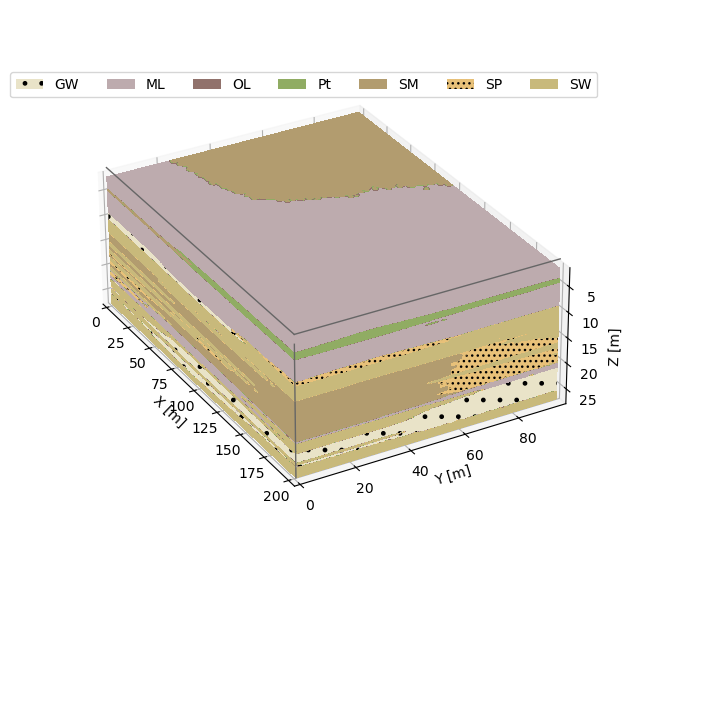

In [113]:
# Create a figure with 3D ax
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
names_uscs = ["GW",
              "ML",
              "OL",
              "Pt",
              "SM",
              "SP",
              "SW"]



newcmp = ListedColormap(lithology_colors)
cmap = newcmp




hatches=['.','...','','','','','']
Rn = ['GW', 'SP', 'SW', 'SM', 'ML', 'OL', 'Pt']  # manual ordering accordieng to soil!
indx = []
for i,c in enumerate(Rn):
    indx.append(R.index(c))

# lithological plots
# SEE: https://towardsdatascience.com/displaying-lithology-data-using-python-and-matplotlib-58b4d251ee7a

uscs_colors = [(0.9137254901960784, 0.8895686274509804, 0.7843921568627451),      
          (0.9090, 0.75640, 0.4750),              
          (0.7843137254901961, 0.7239215686274509, 0.4835294117647059),
          (0.6980392156862745, 0.6134901960784314, 0.4369411764705882),
          (0.7411764705882353, 0.6687058823529413, 0.6831764705882354),
          (0.5686274509803921, 0.4478431372549019, 0.4219607843137255), 
          (0.5660, 0.6740, 0.3880)]


uscs_colors = [uscs_colors[0], 
                    uscs_colors[4],
                    uscs_colors[5],
                    uscs_colors[6],
                    uscs_colors[3],
                    uscs_colors[1],
                    uscs_colors[2] ]


hatches = [hatches[0], 
                    hatches[4],
                    hatches[5],
                    hatches[6],
                    hatches[3],
                    hatches[1],
                    hatches[2] ]



newcmp = ListedColormap(uscs_colors)
cmap = newcmp

# =============================================================================

fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')
x_scale=4
y_scale=3
z_scale=2
scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0

def short_proj():
  return np.dot(Axes3D.get_proj(ax), scale)
ax.get_proj=short_proj

# Set limits of the plot from coord limits
xmin, xmax = X.min(), X.max()
ymin, ymax = Y.min(), Y.max()
zmin, zmax = Z.min(), Z.max()
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])
# Plot contour surfaces
_ = ax.contourf(
    X[:, :, 0], Y[:, :, 0], uscs_mp[:, :, 0], levels = [1,2,3,4,5,6,7,8],
    zdir='z', offset=zmin, cmap=cmap, hatches = hatches
)
_ = ax.contourf(
    X[0, :, :], uscs_mp[0, :, :], Z[0, :, :], levels = [1,2,3,4,5,6,7,8],
    zdir='y', offset=0, cmap=cmap, hatches = hatches
)
C = ax.contourf(
    uscs_mp[:, -1, :], Y[:, -1, :], Z[:, -1, :], levels = [1,2,3,4,5,6,7,8],
    zdir='x', offset=X.max(), cmap=cmap, hatches = hatches
)




# _ = ax.contourf(
#     X[bh_9_loc_y[0][0], :, :], uscs_mp[bh_9_loc_y[0][0], :, :], Z[bh_9_loc_y[0][0], :, :],
#     zdir='y', offset=yy[bh_9_loc_y[0][0]], cmap=cmap, hatches = hatches
# )

# C = ax.contourf(
#     uscs_mp[:, bh_9_loc_x[1][0], :], Y[:, bh_9_loc_x[1][0], :], Z[:, bh_9_loc_x[1][0], :],
#     zdir='x', offset=xx[bh_9_loc_x[1][0]], levels = [1,2,3,4,5,6,7,8], cmap=cmap, hatches = hatches
# )
# --
artists, labels = C.legend_elements()



# Plot edges
edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)

# Set labels and zticks
ax.set(
    xlabel='X [m]',
    ylabel='Y [m]',
    zlabel='Z [m]',
   
)

# Set zoom and angle view
ax.view_init(30, -30, 0)
ax.set_box_aspect(None, zoom=0.9)
ax.invert_zaxis()
ax.legend(artists, names_uscs, bbox_to_anchor=(0.85, 0.92), ncol = num_classes)

# Colorbar
#fig.colorbar(C, ax=ax, fraction=0.02, pad=0.1, label=r'$I_{c}$ ')
plt.savefig(plots_folder+'\\3d_uscs_mp_Ic_sbl1'+'.svg', 
            bbox_inches='tight', dpi=600)
# Show Figure
plt.show()

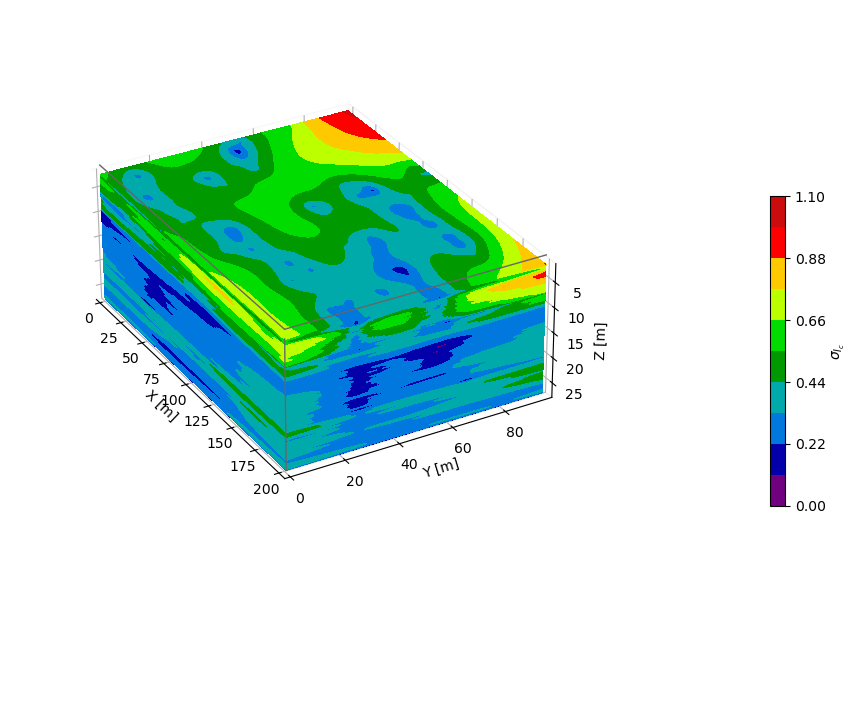

In [244]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

Dx = np.max(xy_sorted[:,0]) - np.min(xy_sorted[:,0])
Dy = np.max(xy_sorted[:,1]) - np.min(xy_sorted[:,1])


xx = np.unique(test_grid_zx_yf_full[1].cpu().numpy())*Dx
yy = np.unique(test_grid_zx_yf_full[2].cpu().numpy())*Dy
zz = np.linspace(np.min(grid[0].numpy()), np.max(grid[0].numpy()), nz) * (np.max(z_mat)-dis_depth / 100) + dis_depth / 100  


metric = stdev_Ic_lgn

X, Y, Z = np.meshgrid(xx, yy, zz)

# Plot

if str(metric) == str(H_3d) or str(metric) == str(max_probs_3d) :
    kw = {
    'vmin': 0,
    'vmax': 1,
    'levels': np.linspace(0, 1, 11),
    'cmap': plt.cm.nipy_spectral
}
elif str(metric) == str(mean_r) or str(metric) == str(upper_Ic) or str(metric) == str(lower_Ic) or str(metric) == str(mean_Ic_lgn)  :
    kw = {
    'levels': [0.00, 1.31, 2.05, 2.6, 2.95, 3.6, 8],
    'cmap': plt.cm.nipy_spectral
}
elif str(metric) == str(stdev_Ic_lgn):   
    kw = {
    'vmin': 0,
    'levels': np.linspace(0, 1.1, 11),
    'cmap': plt.cm.nipy_spectral
}

# Create a figure with 3D ax
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
x_scale=4
y_scale=3
z_scale=2
scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0

def short_proj():
  return np.dot(Axes3D.get_proj(ax), scale)
ax.get_proj=short_proj
def short_proj():
  return np.dot(Axes3D.get_proj(ax), scale)
ax.get_proj=short_proj

# Set limits of the plot from coord limits
xmin, xmax = X.min(), X.max()
ymin, ymax = Y.min(), Y.max()
zmin, zmax = Z.min(), Z.max()
# Plot contour surfaces
_ = ax.contourf(
    X[:, :, 0], Y[:, :, 0], metric[:, :, 0],
    zdir='z', offset=zmin, **kw
)
_ = ax.contourf(
    X[0, :, :], metric[0, :, :], Z[0, :, :],
    zdir='y', offset=0, **kw
)
C = ax.contourf(
    metric[:, -1, :], Y[:, -1, :], Z[:, -1, :],
    zdir='x', offset=X.max(), **kw
)


# Set limits of the plot from coord limits
xmin, xmax = X.min(), X.max()
ymin, ymax = Y.min(), Y.max()
zmin, zmax = Z.min(), Z.max()
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# Plot edges
edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)

# Set labels and zticks
ax.set(
    xlabel='X [m]',
    ylabel='Y [m]',
    zlabel='Z [m]',
   
)

# Set zoom and angle view
ax.view_init(30, -30, 0)
ax.set_box_aspect(None, zoom=0.9)
ax.invert_zaxis()
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# Colorbar
if str(metric) != str(uscs_mp):
    if str(metric) == str(mean_r):
        fig.colorbar(C, ax=ax, fraction=0.02, pad=0.1, label=r'$m_{I_c}$')
        plt.savefig(plots_folder+'\\3d_'+"Ic"+'.svg', 
                 bbox_inches='tight', dpi=600)
    if str(metric) == str(mean_Ic_lgn):
        fig.colorbar(C, ax=ax, fraction=0.02, pad=0.1, label=r'$\mu_{I_c}$')
        plt.savefig(plots_folder+'\\3d_'+"mean_Ic"+'.svg', 
                 bbox_inches='tight', dpi=600)
    elif str(metric) == str(max_probs_3d):
        fig.colorbar(C, ax=ax, fraction=0.02, pad=0.1, label= "max uscs probabilities")
        plt.savefig(plots_folder+'\\3d_'+"max_prob_w_Ic"+'.png', 
                 bbox_inches='tight', dpi=400)
    elif str(metric) == str(H_3d):
        fig.colorbar(C, ax=ax, fraction=0.02, pad=0.1, label= "Entropy")
        plt.savefig(plots_folder+'\\3d_'+"H_w_Ic"+'.svg', 
                 bbox_inches='tight', dpi=600)
    elif str(metric) == str(upper_Ic):
        fig.colorbar(C, ax=ax, fraction=0.02, pad=0.1, label= 'upper Ic')
        plt.savefig(plots_folder+'\\3d_'+"upper_Ic"+'.png', 
                 bbox_inches='tight', dpi=400)
    elif str(metric) == str(lower_Ic):
        fig.colorbar(C, ax=ax, fraction=0.02, pad=0.1, label= 'lower Ic')
        plt.savefig(plots_folder+'\\3d_'+"lower_Ic"+'.png', 
                 bbox_inches='tight', dpi=400)
    elif str(metric) == str(stdev_Ic_lgn):
        fig.colorbar(C, ax=ax, fraction=0.02, pad=0.1, label= r'$\sigma_{I_c}$')
        plt.savefig(plots_folder+'\\3d_'+"stdev_Ic_lgn"+'.svg', 
                 bbox_inches='tight', dpi=600)
    
         
    # plt.savefig(plots_folder+'\\3d_'+str(metric)+'.png', 
    #             bbox_inches='tight', dpi=400)
# Show Figure
plt.show()